# 1. Set Up

In [1]:
!spack find -p tfel

-- linux-ubuntu20.04-x86_64 / gcc@9.4.0 -------------------------
tfel@4.0.0  /mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx
==> 1 installed package


In [2]:
# %env LD_LIBRARY_PATH=/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx/lib

In [3]:
!echo "$(spack find -p tfel | awk '/\/mofem_install\// {print $NF "/lib"}')"

/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx/lib


In [4]:
import math
import os
import re
import sys
import time
import json
from pathlib import Path
import subprocess
import zipfile
import pydantic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import gmsh
from scipy import optimize
from scipy.optimize import curve_fit, least_squares

sys.path.append('/mofem_install/jupyter/thomas/mfront_example_test/src')

import mesh_create as mshcrte
import custom_models as cm
import utils as ut
import plotting


def set_display_configurations(): pass
    # from matplotlib.colors import ListedColormap
    # pv.set_plot_theme("document")

    # plt.rcParams['figure.figsize'] = [12, 9]
    # plt.rcParams['figure.dpi'] = 300
    # plt.rcParams['font.family'] = "DejaVu Serif"
    # plt.rcParams['font.size'] = 20

    # from pyvirtualdisplay import Display
    # display = Display(backend="xvfb", visible=False, size=(800, 600))
    # display.start()
    
set_display_configurations()
os.chdir('/mofem_install/jupyter/thomas/mfront_example_test')
    


# 2. Simulation Parameters

In [5]:
def initialize_parameters():
    params = mshcrte.AttrDict()
    params.pile_manager = cm.PileManager(x=0, y=0, z=10, dx=0, dy=0, dz=-20.5, R=1, r=0.975,
                                preferred_model= cm.PropertyTypeEnum.elastic,
                                props = {
                                    cm.PropertyTypeEnum.elastic: cm.ElasticProperties(youngs_modulus=200000*(10**6), poisson_ratio=0.3),
                                    cm.PropertyTypeEnum.saint_venant_kirchhoff: cm.ElasticProperties(youngs_modulus=200000*10**6, poisson_ratio=0.3),
                                },
                                )

    soil_layer_1 = cm.SoilLayer(
        depth = -2,
        preferred_model= cm.PropertyTypeEnum.elastic,
        props = {
            cm.PropertyTypeEnum.elastic: cm.ElasticProperties(youngs_modulus=96*10**6, poisson_ratio=0.3),
            cm.PropertyTypeEnum.saint_venant_kirchhoff: cm.ElasticProperties(youngs_modulus=182.1*10**6, poisson_ratio=0.3),
            cm.PropertyTypeEnum.isotropic_hardening: cm.IsotropicLinearHardeningPlasticityProperties(youngs_modulus=96*10**6, poisson_ratio=0.3,HardeningSlope = 10.e9, YieldStress = 300.e6),
            cm.PropertyTypeEnum.drucker_prager: cm.ElasticProperties(youngs_modulus=96*10**6, poisson_ratio=0.3),
            cm.PropertyTypeEnum.cam_clay: cm.CamClayProperties(),
            }, 
            )
    soil_layer_2 = cm.SoilLayer(
        depth = -1.4,
        preferred_model= cm.PropertyTypeEnum.elastic,
        props = {
            cm.PropertyTypeEnum.elastic: cm.ElasticProperties(youngs_modulus=182.1*10**6, poisson_ratio=0.3),
            cm.PropertyTypeEnum.saint_venant_kirchhoff: cm.ElasticProperties(youngs_modulus=182.1*10**6, poisson_ratio=0.3),
            cm.PropertyTypeEnum.isotropic_hardening: cm.IsotropicLinearHardeningPlasticityProperties(youngs_modulus=96*10**6, poisson_ratio=0.3,HardeningSlope = 10.e9, YieldStress = 300.e6),
            cm.PropertyTypeEnum.drucker_prager: cm.ElasticProperties(youngs_modulus=182.1*10**6, poisson_ratio=0.3),
            cm.PropertyTypeEnum.cam_clay: cm.CamClayProperties(),
            }, 
            )
    soil_layer_3 = cm.SoilLayer(
        depth = -7.1,
        preferred_model= cm.PropertyTypeEnum.elastic,
        props = {
            cm.PropertyTypeEnum.elastic: cm.ElasticProperties(youngs_modulus=351.3*10**6, poisson_ratio=0.3),
            cm.PropertyTypeEnum.saint_venant_kirchhoff: cm.ElasticProperties(youngs_modulus=182.1*10**6, poisson_ratio=0.3),
            cm.PropertyTypeEnum.isotropic_hardening: cm.IsotropicLinearHardeningPlasticityProperties(youngs_modulus=96*10**6, poisson_ratio=0.3,HardeningSlope = 10.e9, YieldStress = 300.e6),
            cm.PropertyTypeEnum.drucker_prager: cm.ElasticProperties(youngs_modulus=351.3*10**6, poisson_ratio=0.3),
            cm.PropertyTypeEnum.cam_clay: cm.CamClayProperties(),
                 }, 
            )
    soil_layer_4 = cm.SoilLayer(
        depth = -19,
        preferred_model= cm.PropertyTypeEnum.elastic,
        props = {
            cm.PropertyTypeEnum.elastic: cm.ElasticProperties(youngs_modulus=668.4*10**6, poisson_ratio=0.3),
            cm.PropertyTypeEnum.saint_venant_kirchhoff: cm.ElasticProperties(youngs_modulus=182.1*10**6, poisson_ratio=0.3),
            cm.PropertyTypeEnum.isotropic_hardening: cm.IsotropicLinearHardeningPlasticityProperties(youngs_modulus=96*10**6, poisson_ratio=0.3,HardeningSlope = 10.e9, YieldStress = 300.e6),
            cm.PropertyTypeEnum.drucker_prager: cm.ElasticProperties(youngs_modulus=668.4*10**6, poisson_ratio=0.3),
            cm.PropertyTypeEnum.cam_clay: cm.CamClayProperties(),
            }, 
            )
    params.interface_manager = cm.InterfaceManager(
        preferred_model = cm.PropertyTypeEnum.elastic,
        props = {
            cm.PropertyTypeEnum.elastic: cm.ElasticProperties(youngs_modulus=96*10**6, poisson_ratio=0.3),
            cm.PropertyTypeEnum.saint_venant_kirchhoff: cm.ElasticProperties(youngs_modulus=182.1*10**6, poisson_ratio=0.3),
            cm.PropertyTypeEnum.isotropic_hardening: cm.IsotropicLinearHardeningPlasticityProperties(youngs_modulus=96*10**6, poisson_ratio=0.3,HardeningSlope = 10.e9, YieldStress = 300.e6),
            cm.PropertyTypeEnum.drucker_prager: cm.ElasticProperties(youngs_modulus=96*10**6, poisson_ratio=0.3),
            cm.PropertyTypeEnum.cam_clay: cm.CamClayProperties(),
            },
            )
    # params.prescribed_force = cm.ForceBoundaryCondition(fx=-18*10**6,fy=0,fz=0)
    params.prescribed_disp = cm.SurfaceBoundaryCondition(disp_ux=-1)
    params.box_manager = cm.BoxManager(x=-80, y=-80, z=0, dx=160, dy=80,
        layers=[
        soil_layer_1,
        soil_layer_2,
        soil_layer_3,
        soil_layer_4,
        ],
        far_field_size=10,
        near_field_dist=5,
        near_field_size=0.5,
    )

    params.nproc = 8 # number of processors/cores used
    params.order = 2 #order of approximation functions

    params.time_step = 0.05 # [s]
    params.final_time = 1 # [s]

    return params

In [6]:
params = initialize_parameters()

# 3. Log paths and meta

In [7]:
def days_since_epoch():
    epoch_date = time.strptime("2024-08-17", "%Y-%m-%d")
    epoch_seconds = time.mktime(epoch_date)
    # Get the current time
    current_seconds = time.time()
    # Calculate days since the epoch
    days_since_epoch = int((current_seconds - epoch_seconds) // (24 * 3600))
    return days_since_epoch

def log_sim_entry(params):
    params.global_log_file = params.wk_dir / "simulations/simulation_log.json"
    
    # Load existing logs if the log file exists
    if params.global_log_file.exists():
        with open(params.global_log_file, 'r') as f:
            logs = json.load(f)
    else:
        logs = {}

    # Create the params dictionary for the log entry
    params_dict = {
        "pile_manager": params.pile_manager.model_dump(serialize_as_any=True),
        "box_manager": params.box_manager.model_dump(serialize_as_any=True),
        "prescribed_force": params.prescribed_force.model_dump() if getattr(params, 'prescribed_force', None) else None,
        "prescribed_disp": params.prescribed_disp.model_dump() if getattr(params, 'prescribed_disp', None) else None,
    }

    # Filter simulations for today and count simulations with the same parameters
    params.prior_sims_with_same_params = [log for log in logs.values() if log['params'] == params_dict]
    # params.prior_sims_with_same_params_no = len(params.prior_sims_with_same_params)
    # params.new_sim_number_with_same_params = params.prior_sims_with_same_params_no + 1
    params.new_sim_number = len(logs) + 1
    # Determine simulation number for today prior to this simulation
    params.prior_sims_today = len([log for log in logs.values() if log['date_of_sim'] == params.date_of_sim])
    params.new_sim_number_today = params.prior_sims_today + 1

    # Create the log entry as a dictionary
    log_entry = {
        "days_since_epoch": params.days_since_epoch,
        "sim_number_of_the_day": params.new_sim_number_today,
        "date_of_sim": params.date_of_sim,
        "time_of_sim": params.time_of_sim,
        # "sim_number_with_same_params": params.new_sim_number_with_same_params,
        "params": params_dict,
    }

    # Add the new entry to the logs
    logs[f"{params.new_sim_number}"] = log_entry
    log_dir = params.wk_dir / "simulations"
    log_dir.mkdir(parents=True, exist_ok=True)
    
    if not os.path.exists(params.global_log_file):
        with open(params.global_log_file, 'w'): pass
    # Write the logs back to the JSON file
    with open(params.global_log_file, 'w') as f:
        json.dump(logs, f, indent=4)

    print(f"Simulation #{params.new_sim_number_today} for the day.")
    # print(f"Simulation #{params.new_sim_number_with_same_params} with the same parameters.")

    # if params.prior_sims_with_same_params_no > 0:
    #     # Get the datetime of the previous simulation
    #     previous_simulation = params.prior_sims_with_same_params[-1]
    #     print(f"Previous simulation with the same parameters was run on: day {previous_simulation['days_since_epoch']} simulation {previous_simulation['sim_number_today']}")
    return params

def initialize_paths(params):

    params.simulation_name = f"day_{params.days_since_epoch}_sim_{params.new_sim_number_today}_{params.time_of_sim}"
    params.mesh_name = f"day_{params.days_since_epoch}_sim_{params.new_sim_number_today}"

    # Continue with the rest of the simulation setup
    params.data_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test/simulations/{params.simulation_name}")
    params.data_dir.mkdir(parents=True, exist_ok=True)

    params.template_sdf_file = params.wk_dir / f"src/template_sdf.py"
    params.sdf_file = params.wk_dir / f"src/sdf.py"


    params.med_filepath = params.data_dir / f"{params.mesh_name}.med"
    params.h5m_filepath = params.data_dir / f"{params.mesh_name}.h5m"
    params.vtk_filepath = params.data_dir / f"{params.mesh_name}.vtk"
    params.csv_filepath = params.data_dir / f"{params.mesh_name}.csv"
    params.part_file = os.path.splitext(params.h5m_filepath)[0] + "_" + str(params.nproc) + "p.h5m"

    params.read_med_initial_log_file = params.data_dir / f"{params.mesh_name}_read_med.log"

    # params.bc_time_history = params.data_dir / "disp_time.txt"
    params.config_file = params.data_dir / "bc.cfg"
    params.log_file = params.data_dir /  f"result_{params.mesh_name}.log"
    if not os.path.exists(params.log_file):
        with open(params.log_file, 'w'): pass

    return params



# sys.exit()

In [8]:
params.days_since_epoch = days_since_epoch()
    
params.time_of_sim = time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())
params.date_of_sim = time.strftime("%Y_%m_%d", time.localtime())

# File paths and directories
params.wk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test")
params = log_sim_entry(params)
# print(params.pile_manager)
# print(params.pile_manager.model_dump(serialize_as_any=True))
# print(params.pile_manager.model_dump(serialize_as_any=False))
# sys.exit()
params = initialize_paths(params)
params.user_name = !whoami
params.user_name = params.user_name[0]
params.um_view = f"/mofem_install/jupyter/{params.user_name}/um_view"

Simulation #7 for the day.


# 4. Generate the mesh

In [9]:
geo = mshcrte.draw_mesh(params)
params.physical_groups = mshcrte.add_physical_groups(params, geo)
params.physical_groups = mshcrte.check_block_ids(params,params.physical_groups)
params.physical_groups = mshcrte.generate_config(params,params.physical_groups)
mshcrte.inject_configs(params)
mshcrte.partition_mesh(params)

╭────────────────╮
│  DRAWING MESH  │
╰────────────────╯
[1, 2, 3, 4]
[6]
[(3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6)]
Done, taken Wall Time: 0.07 seconds, CPU Time: 0.07 seconds
╭──────────────────────────────────╮
│  ADDING PHYSICAL GROUPS TO MESH  │
╰──────────────────────────────────╯


Done, taken Wall Time: 2.40 seconds, CPU Time: 2.40 seconds
╭──────────────────────╮
│  CHECKING BLOCK IDS  │
╰──────────────────────╯
{'day_16_sim_7': 1, 'CYLINDER': 2, 'FIX_ALL': 3, 'FIX_X_0': 4, 'FIX_X_1': 5, 'FIX_Y_0': 6, 'FIX_Z_0': 7, 'INTERFACE': 8, 'SOIL_LAYER_0': 9, 'SOIL_LAYER_1': 10, 'SOIL_LAYER_2': 11, 'SOIL_LAYER_3': 12}
Done, taken Wall Time: 0.29 seconds, CPU Time: 0.00 seconds
╭───────────────────────────╮
│  GENERATING CONFIG FILES  │
╰───────────────────────────╯
Done, taken Wall Time: 0.00 seconds, CPU Time: 0.00 seconds
╭───────────────────────────────────────╮
│  INJECTING CONFIG FILE with read_med  │
╰───────────────────────────────────────╯


[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <inform> Local time: 2024-9-2 21:53:58
[0] <inform> UTC time: 2024-9-2 21:53:58
[0] <inform> [MED] Reading MED file V4.1.0 using MED library V4.1.0
[0] <inform> [MED] Check mesh day_16_sim_7 nsteps 1
[0] <inform> [MED] Reading mesh day_16_sim_7 nsteps 1
[0] <inform> [MED] Read number of nodes 10799
[0] <inform> [MED] Reading elements 3217 of type Tri number of nodes 3
[0] <inform> [MED] Reading elements 46663 of type Tet number of nodes 4
[0] <inform> [read_med] Print all meshsets (old and added from meshsets configurational file)
[0] <inform> [read_med] meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name day_16_sim_7
[0] <inform> [read_med] meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name CYLINDER                       
[0] <inform> [read_med] meshset 12682136550675316739 type BLOCKSET UNKNOW

Done, taken Wall Time: 0.25 seconds, CPU Time: 0.00 seconds
╭─────────────────────────────────────╮
│  PARTITIONING MESH with mofem_part  │
╰─────────────────────────────────────╯


[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <inform> Local time: 2024-9-2 21:53:58
[0] <inform> UTC time: 2024-9-2 21:53:58
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name day_16_sim_7
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name CYLINDER                       
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 3 name FIX_ALL                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 4 name FIX_X_0                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316741 type BLOCKSET UNKNOWNNAME msId 5 name FIX_X_1                        
[0] <inform> [MeshsetMng] meshset in database meshs

Done, taken Wall Time: 1.74 seconds, CPU Time: 0.00 seconds


# 5. Running the analysis and export to .vtk file format

In [10]:
mshcrte.mofem_compute(params) #calling the func from the module


╭─────────────╮
│  COMPUTING  │
╰─────────────╯
[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <inform> Local time: 2024-9-2 21:54:1
[0] <inform> UTC time: 2024-9-2 21:54:1
[0] <warning> [MeshsetMng] broadcasted vertex 1312 has negative id
[0] <warning> [MeshsetMng] broadcasted vertex 1310 has negative id
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 1 name day_16_sim_7
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316772 type BLOCKSET UNKNOWNNAME msId 2 name CYLINDER                       
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 3 name FIX_ALL                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316771 type BLOCKSET UNKNOWNNAME msId 4 name FIX_X_0                        
[0] <inform> [Me

In [11]:
mshcrte.export_to_vtk(params)

╭────────────────────────────────╮
│  CONVERTING FROM .htm TO .vtk  │
╰────────────────────────────────╯


Conversion to VTK successful.
Moved out_mi_8.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/day_16_sim_7_2024_09_02_21_53_55
Moved out_mi_6.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/day_16_sim_7_2024_09_02_21_53_55
Moved out_mi_7.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/day_16_sim_7_2024_09_02_21_53_55
Moved out_mi_9.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/day_16_sim_7_2024_09_02_21_53_55
Moved out_mi_5.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/day_16_sim_7_2024_09_02_21_53_55
Moved out_mi_4.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/day_16_sim_7_2024_09_02_21_53_55
Moved out_mi_20.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/day_16_sim_7_2024_09_02_21_53_55
Moved out_mi_19.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/day_16_sim_7_2024_09_02_21_53_55
Moved out_mi_17.vtk to /mofem_in

# 6. Extract data from .vtk file with pvpython, then plotting

In [20]:
!/mofem_install/jupyter/thomas/ParaView-5.13.0-RC1-MPI-Linux-Python3.10-x86_64/bin/pvpython /mofem_install/jupyter/thomas/mfront_example_test/src/paraview_test.py {params.vtk_filepath} {params.data_dir}

╭───────────────────────────────────╮
│  EXTRACTING GROUP DATA FROM .vtk  │
╰───────────────────────────────────╯
Read Success
Done, taken Wall Time: 44.91 seconds, CPU Time: 68.74 seconds
╭─────────────────────────────╮
│  EXTRACTING DATA FROM .vtk  │
╰─────────────────────────────╯
Read Success
Done, taken Wall Time: 1.09 seconds, CPU Time: 6.19 seconds


╭─────────────────────────────────╮
│  PLOTTING STRESS AGAINST DEPTH  │
╰─────────────────────────────────╯


KeyError: 'STRESS:0'

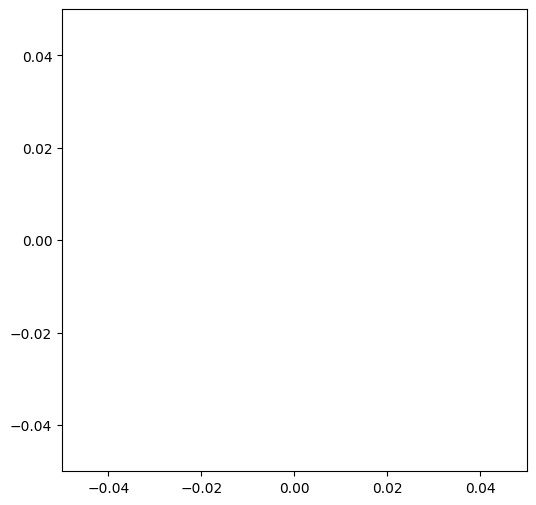

In [21]:
plotting.calculate_and_plot_q_p(
    {"Compression at x = 1m": f'{params.data_dir}/dis_to_time_compression_mudline.csv', 
     }, 
    f"{params.data_dir}/result_q_p.png")
    #  "Compression at x = 1.1m": f'{params.data_dir}/dis_to_time_mudline_x_1.csv'

plotting.plot_displacement_vs_points(
    {"Compression at x = 1m": f'{params.data_dir}/dis_to_depth_compression_x_1.csv', 
     "Compression at x = 1.1m": f'{params.data_dir}/dis_to_depth_compression_x_1.1.csv'}, 
    f"{params.data_dir}/result_disp.png")


plotting.plot_stress_vs_points(
    {"Compression at x = 1m": f'{params.data_dir}/dis_to_depth_compression_x_1.csv', 
     "Compression at x = 1.1m": f'{params.data_dir}/dis_to_depth_compression_x_1.1.csv'}, 
    f"{params.data_dir}/result_stress.png")






In [14]:
# raise SystemExit("")